# Banking Marketing -  Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



Imports:

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import RocCurveDisplay, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y). The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date, very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

**For this specific project the bank-additional-full.csv dataset will be used**.

Additional information:

According to the provided paper, the dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable). For the whole database considered in the paper, there were 6499 successes (8% success rate). 

Note: The success rate in the dataset used is slightly different. To check the success rate of the campaign go to Problem 2.



### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [34]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [35]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Failure and Success rate of the campaign**

The code below calculates the failure rate of the marketing campaign. It does so by first selecting only the 'y' column using df[['y']], it then applies a boolean query filter only keeping those rows where 'y' is 'no' (query("y=='no'")), and finally, it counts these rows using count(). The number of rows where 'y' is 'no' (the number of 'failures') is divided by the total number of rows in the 'y' column to get the failure rate. In a similar logic the success rate is calculated.

In [36]:
failure_rate = df[['y']].query("y=='no'").count() / df['y'].count()

success_rate = (df[['y']].query("y=='yes'").count() / df['y'].count())

print('The failure rate of the marketing campaign is: '+str(round(failure_rate.iloc[0],3)*100)+'%' )
print('The success rate of the marketing campaign is: '+str(round(success_rate.iloc[0],3)*100)+'%' )

The failure rate of the marketing campaign is: 88.7%
The success rate of the marketing campaign is: 11.3%


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')


# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)



Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



**According to the above data description**:

- **Numeric Variables**: 'age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', and 'nr.employed' are described as numeric. Before proceeding, I should confirm if they are correctly stored as integers or floats. If I find any anomalies (like numeric values stored as strings), coercion to the correct datatype will be required.

- **Categorical Variables**: Variables like 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', and 'poutcome' are described as categorical. Is should ensure these are appropriately categorized, and consider encoding them using techniques like one-hot encoding or ordinal encoding, based on my analysis or modelling requirements.

- **(Optional) Unknown Values**: I noticed that for some categorical variables like 'job', 'marital', 'education', 'default', 'housing', and 'loan' there is an 'unknown' category. Depending on the context and the analysis requirement, these 'unknown' categories might be treated as missing values.

- **Special Notes**: The 'duration' variable should be dropped - the description suggests avoiding usage of this variable if the intention is to create a predictive model.

- **Output Variable**: The output variable 'y' is binary and may need to be encoded to 0 and 1 if the modeling technique I plan to use requires numerical input.

In [37]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Numeric features of type int:

In [38]:
print('Numeric Features of type int64:')
int64_feat = df.select_dtypes(include='int64').columns.tolist()
print(int64_feat )

df[int64_feat].head(5)

Numeric Features of type int64:
['age', 'duration', 'campaign', 'pdays', 'previous']


,age,duration,campaign,pdays,previous
0,56,261,1,999,0
1,57,149,1,999,0
2,37,226,1,999,0
3,40,151,1,999,0
4,56,307,1,999,0


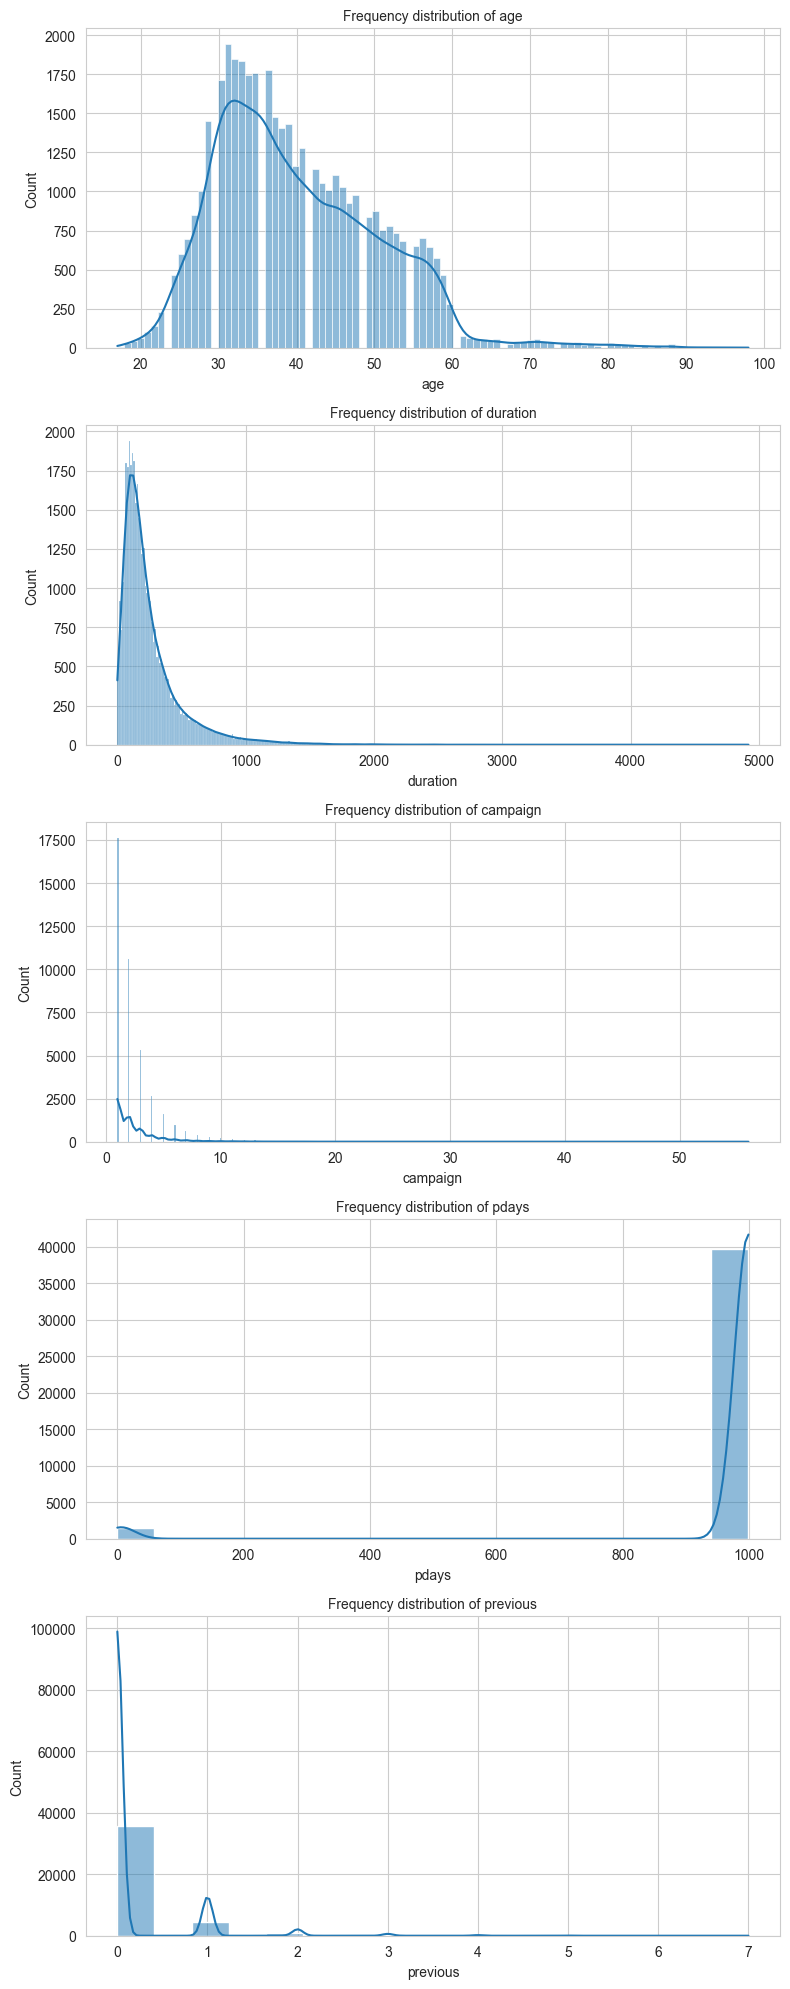

In [39]:
# numeric features of type int64
# plotting their distributions:
fig, axs = plt.subplots(len(int64_feat), figsize=(8, 4*len(int64_feat)))  # Adjust the size as necessary

for i, col_val in enumerate(int64_feat):
    sns.histplot(df[col_val], kde=True, ax=axs[i])
    axs[i].set_title('Frequency distribution of ' + str(col_val), fontsize=10)

plt.tight_layout()
plt.show()

The pdays feature represents the number of days that passed by after the client was last contacted from a previous campaign. It's a numeric feature, but the value 999 is used to indicate that the client hasn't been previously contacted. 

There are many ways to address this feature:
- Binary Transformation: Given that a large proportion of the pdays values might be 999, I can create a binary feature that indicates whether the customer had been previously contacted or not. Here, I can turn pdays into a binary feature where 'yes' indicates that the customer was contacted before, and 'no' indicates that they weren't.
- Missing Value Imputation: I can treat 999 values as missing values or NaN. After replacing 999 with NaN, pdays will only contain the actual number of days that passed for previously contacted customers. I can then decide how to handle these missing values depending on the context or the ML model I will use. Some models can handle NaN values inherently.
- Bucketing: I could retain the numeric nature of the variable but group the '999' values into a separate bucket. Bucketing or Binning can alleviate the effects of noisy data and help improve model robustness and performance. I might categorize '1-30', '31-60', '61-90', 'Over 90', 'Not Contacted', etc.

I should decide how to transform it by checking the frequency of every value:

In [40]:
#### grouping different values and applying the counting aggregator:
df[['pdays']].groupby('pdays').size()

pdays
0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39673
dtype: int64

According to the above analysis I could binarise the pdays feature. In other words I will create the feature contracted_before to use it in my modelling phase:

In [46]:
df['contacted_before'] = np.where(df['pdays'] != 999, 'yes', 'no')
df['contacted_before'].unique()

# dropping the feature:
df.drop(['pdays'],axis = "columns",inplace=True)


Note: Business wise, the 'previous' feature is closely connected in logic with the newly created 'contacted_before' feature.

In [48]:
#### grouping different values and applying the counting aggregator:
df[['previous']].groupby('previous').size()

previous
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
dtype: int64

The above numeric features of type int64 will be standardised during the feature engineering phase. Now I should check the numeric features of type float64:

In [49]:
print('Numeric Features of type float64:')
float64_feat = df.select_dtypes(include='float64').columns.tolist()
print(float64_feat )

df[float64_feat].head(5)

Numeric Features of type float64:
['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.1,93.994,-36.4,4.857,5191.0
1,1.1,93.994,-36.4,4.857,5191.0
2,1.1,93.994,-36.4,4.857,5191.0
3,1.1,93.994,-36.4,4.857,5191.0
4,1.1,93.994,-36.4,4.857,5191.0


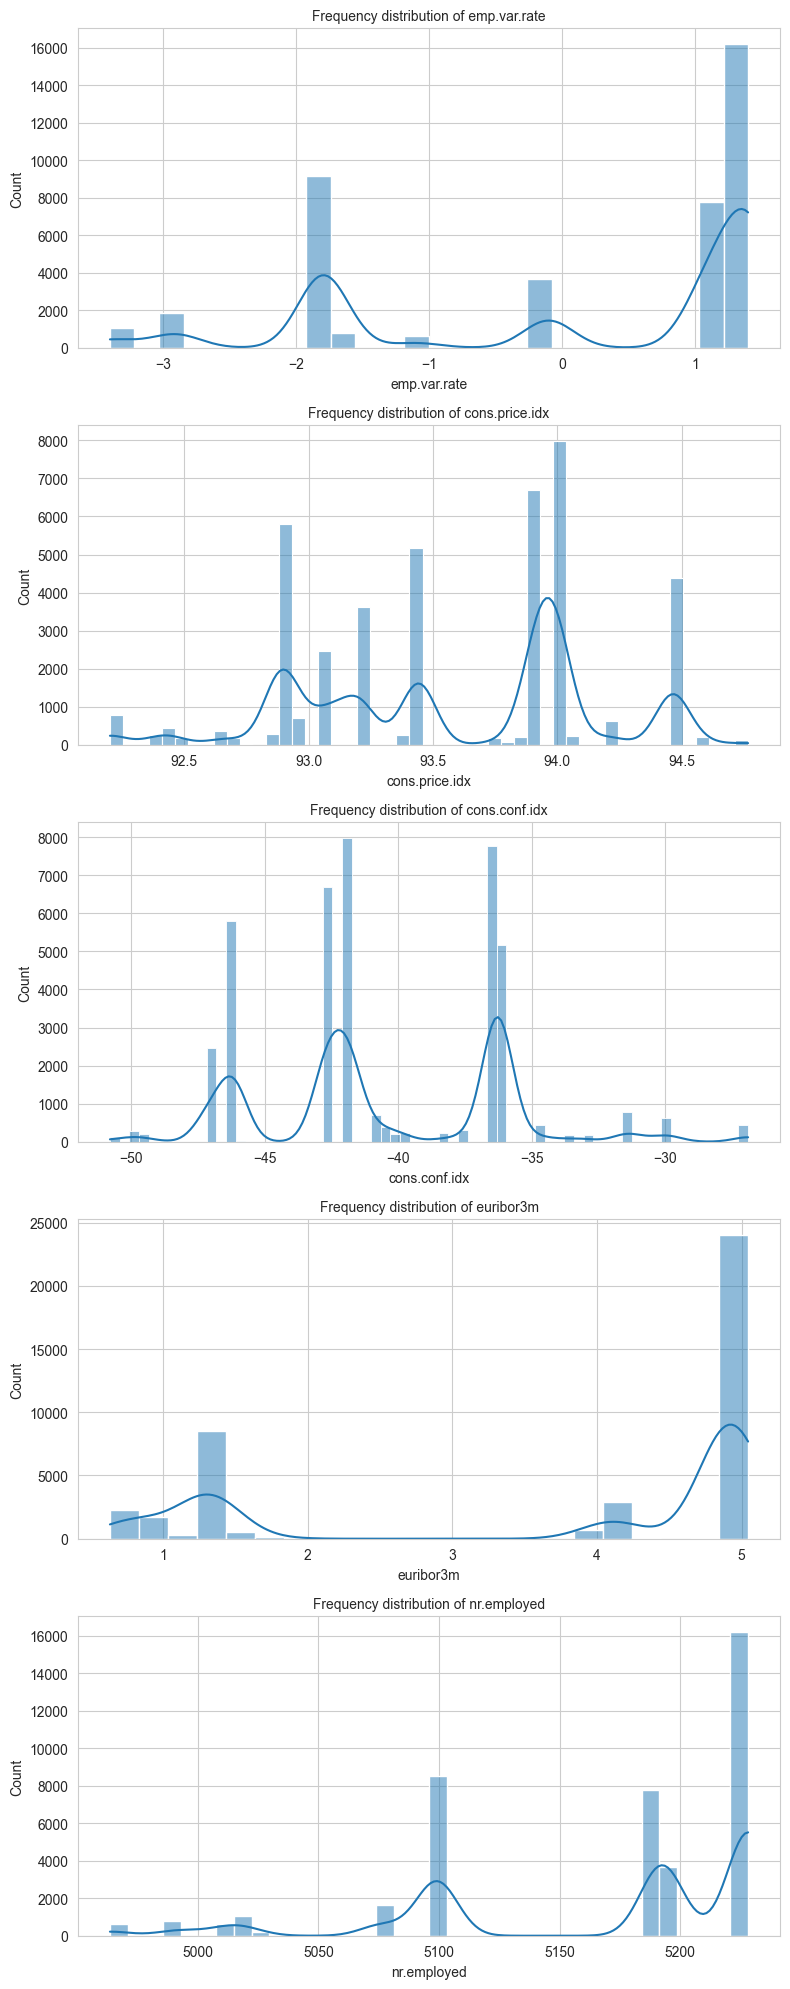

In [51]:
# numeric features of type int64
# plotting their distributions:
fig, axs = plt.subplots(len(float64_feat), figsize=(8, 4*len(float64_feat)))  # Adjust the size as necessary

for i, col_val in enumerate(float64_feat):
    sns.histplot(df[col_val], kde=True, ax=axs[i])
    axs[i].set_title('Frequency distribution of ' + str(col_val), fontsize=10)

plt.tight_layout()
plt.show()

The above numeric float variables are of indexes. The above variables will be standardised during the feature engineering phase. Now let's have a look to the descriptive statistics of numeric features:

In [53]:
df.describe()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


According to the results below, there are no missing values in any of the features.

In [44]:
print('Missing values per feature:')
print(df.isna().sum() )

Missing values per feature:
age                 0
job                 0
marital             0
education           0
default             0
housing             0
loan                0
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
contacted_before    0
dtype: int64


In [45]:
print('Total Missing values:')
print(df.isna().sum().sum() )

Total Missing values:
0


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective:

**To develop a predictive model that can help the bank identify potential customers who are likely to subscribe to a term deposit. Such a model can help the bank focus its marketing efforts more efficiently, targeting those customers that are most likely to respond positively.**


This will entail properly processing the dataset, dealing with any missing or 'unknown' data, appropriately handling categorical and numerical data, and possibly feature engineering. After this, a suitable classification model can be chosen and trained on the dataset. The performance of the model will then be evaluated and if satisfactory, the model can then be deployed for the bank's usage for its marketing campaign.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions